In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
import sys
from scipy.stats import linregress

In [2]:
from config_account_reader import ConfigAccountReader
config_accout_reader = ConfigAccountReader('config_account.yaml')
exchange_name = config_accout_reader.get_exchange_name()
symbol = config_accout_reader.get_market_symbol()
public_key = config_accout_reader.get_public_key()
secret = config_accout_reader.get_secret_key()

# I need the exchange 

#### https://docs.ccxt.com/en/latest/manual.html#configuring-api-keys

In [3]:
# from variable id
exchange_id = exchange_name
exchange_class = getattr(ccxt, exchange_id)
exchange = exchange_class({
    'apiKey': public_key,
    'secret': secret,
})

In [4]:
from config_strategy_reader import ConfigStrategyReader
config_strategy_reader = ConfigStrategyReader('config_strategy.yaml')

position_size = config_strategy_reader.get_position_size()
check_orders_frequency = config_strategy_reader.get_check_orders_frequency()
filded_order_status = config_strategy_reader.get_filled_order_status()

num_buy_grid_lines = config_strategy_reader.get_num_buy_grid_lines()
num_sell_grid_lines = config_strategy_reader.get_num_sell_grid_lines()
grid_size = config_strategy_reader.get_grid_size()

In [5]:
markets = exchange.load_markets()
symbols = [item for item in markets if item.endswith('USDT')]
print(f'Amount of pair of market: {len(symbols)}')

Amount of pair of market: 415


#### Time stamps for stepping back in time

In [6]:
days = 1
weeks = 4
now = datetime.now()
back = now - timedelta(days=days)
back_timestamp = int(back.timestamp()*1000)
print(f'now: {now} minus weeks: {weeks} is back time: {back}\nback timestamp is {back_timestamp}')

now: 2022-12-05 08:35:45.515422 minus weeks: 4 is back time: 2022-12-04 08:35:45.515422
back timestamp is 1670139345515


#### Set pair == market

In [7]:
for_pair = 'BTC/USDT'

### Get all ohlcv for pair - function

In [8]:
def get_all_ohlcv_for_pair(for_pair, since):
    period = '1m'
    all_ohlcv = []
    
    ohlcv = exchange.fetch_ohlcv(for_pair, period, since=since, limit=1000)
    all_ohlcv.extend(ohlcv)
    
    while(len(ohlcv)==1000):
        since_time_stamp = ohlcv[-1][0]
        ohlcv = exchange.fetch_ohlcv(symbol, period, since=since_time_stamp, limit=1000)
        all_ohlcv.extend(ohlcv)
        
    return all_ohlcv

In [9]:
def make_data_frame(ohlcv):
    df = pd.DataFrame(ohlcv)
    df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.set_index('Time', inplace=True)
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.astype(float)
    
    return df

In [10]:
def get_slope_intercept_std_err(df):
    
    slope, intercept, r_value, p_value, std_err = linregress(x=df['Number'], y=df['Close'])
    print(f'slope: {slope},\n'
          f'intercept: {intercept},\n'
          f'r_value: {r_value},\n'
          f'p_value: {p_value},\n'
          f'std_err: {std_err}')
    df['Closetrend'] = slope * df['Number'] + intercept
    
    return slope, intercept, std_err
    

# The main

In [11]:
import mplfinance as mpf

In [12]:
ohlcv = get_all_ohlcv_for_pair(symbol, back_timestamp)
df = make_data_frame(ohlcv)
print(df)

                         Open      High       Low     Close     Volume
Time                                                                  
2022-12-04 07:36:00  16994.54  16995.67  16989.00  16993.22  160.85844
2022-12-04 07:37:00  16992.80  16995.11  16989.00  16994.03   97.31406
2022-12-04 07:38:00  16994.44  16994.78  16991.67  16992.77   47.47839
2022-12-04 07:39:00  16992.77  16995.97  16992.77  16994.92   72.13798
2022-12-04 07:40:00  16994.29  16995.00  16991.91  16993.34   72.98975
...                       ...       ...       ...       ...        ...
2022-12-05 07:31:00  17313.04  17315.87  17312.28  17315.19   40.93412
2022-12-05 07:32:00  17315.19  17315.88  17312.95  17313.95   63.47992
2022-12-05 07:33:00  17313.50  17315.14  17308.15  17308.91   84.11855
2022-12-05 07:34:00  17308.90  17313.93  17307.29  17312.30   96.10852
2022-12-05 07:35:00  17312.30  17317.34  17312.30  17315.30   73.05898

[1441 rows x 5 columns]


C:\Users\Romek\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


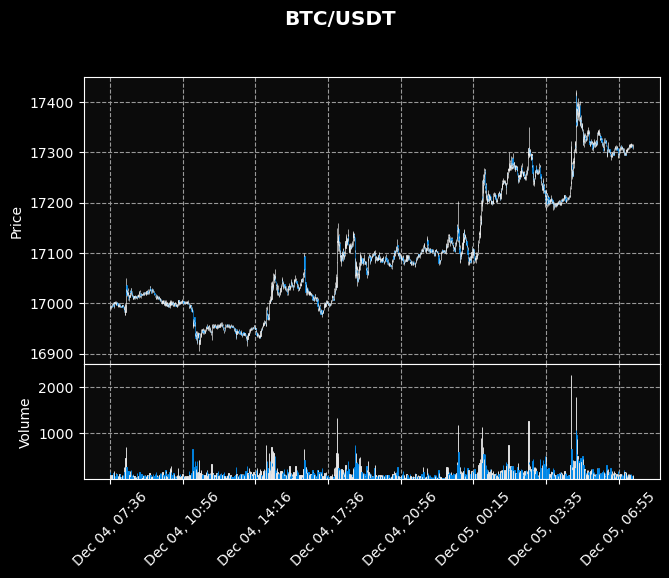

In [13]:
mpf.plot(df, type='candle', volume=True, title=for_pair, style='nightclouds')


#### Analysis of the maximum, minimum and density of price levels

In [14]:
all_values = []

In [15]:
all_values.extend(df.Open.values)
all_values.extend(df.High.values)
all_values.extend(df.Low.values)
all_values.extend(df.Close.values)

In [16]:
df_all_values = pd.DataFrame(data=all_values)

In [17]:
df_all_values.value_counts()

16950.00    6
16948.00    6
16951.15    5
17100.00    5
16997.44    5
           ..
17037.54    1
17037.60    1
17037.75    1
17037.85    1
17424.25    1
Length: 4462, dtype: int64

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

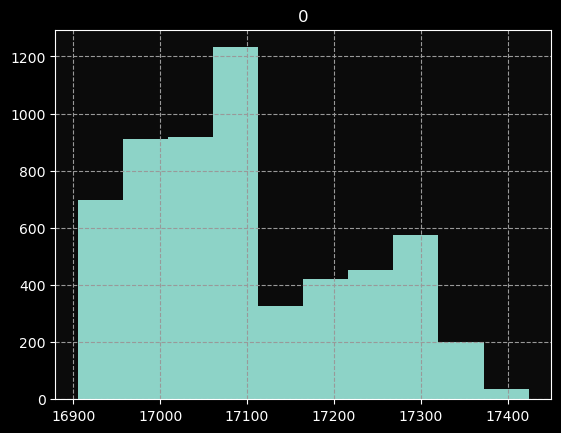

In [23]:
df_all_values.hist(bins=10)

In [19]:
import numpy as np

In [20]:
count, division = np.histogram(all_values)

In [21]:
count

array([ 697,  910,  917, 1232,  328,  420,  452,  574,  199,   35],
      dtype=int64)

In [22]:
division

array([16905.01 , 16956.934, 17008.858, 17060.782, 17112.706, 17164.63 ,
       17216.554, 17268.478, 17320.402, 17372.326, 17424.25 ])